## Defense Strategy 1: Auto Encoder

- @Author: Genevieve, Charles:
- @Co: Minh
- @Team: Clare, Sai

Resources:
- https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/
- https://www.pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/
- https://towardsdatascience.com/simplifing-image-outlier-detection-with-alibi-detect-6aea686bf7ba


In [33]:
!pip install alibi_detect

In [34]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
!pip install opencv-python

In [36]:
!pip install alibi_detect

In [37]:
!ls /content/drive/Shareddrives/EthanFanClub/data/pickled_images

clean_test_images.pkl	       clean_training_images.pkl
clean_test_images_size_32.pkl  clean_training_images_size_32.pkl


In [38]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
import shutil
from collections import Counter
import tensorflow as tf

import logging
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense
from tensorflow.keras.layers import Flatten, Layer, Reshape, InputLayer
from tensorflow.keras.regularizers import l1
from alibi_detect.od import OutlierAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Dense, Layer, Reshape, InputLayer, Flatten, Input, MaxPooling2D
import pickle

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def read_in_images():
  clean_train = "/content/drive/Shareddrives/EthanFanClub/data/pickled_images/clean_training_images_size_32.pkl" # training path
  pickle_off = open(clean_train, "rb")
  ims = pickle.load(pickle_off)
  plt.imshow(ims[0])


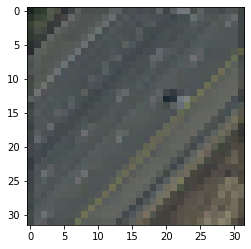

In [40]:
read_in_images()

In [41]:
  save_model_path = "/content/drive/Shareddrives/EthanFanClub/ae.sav"
  clean_train = "/content/drive/Shareddrives/EthanFanClub/data/pickled_images/clean_training_images_size_32.pkl" # training path
  clean_test = "/content/drive/Shareddrives/EthanFanClub/data/pickled_images/clean_test_images_size_32.pkl" # validation path
  with open(clean_test, 'rb') as im: clean_test_imgs = pickle.load(im)
  with open(clean_train, 'rb') as im: clean_train_imgs = pickle.load(im) #load in the training images


In [42]:
def conv_sandwich():
  #lil squares   
  # img_size=[200,200,3]
  
  #pull data, unpickle 

  # clean_train = "/TeamVT/pickled_images/clean_training_images.pkl" # training
  # clean_test = "/TeamVT/pickled_images/clean_test_images.pkl" # validation
  save_model_path = "/content/drive/Shareddrives/EthanFanClub/ae.sav"
  clean_train = "/content/drive/Shareddrives/EthanFanClub/data/pickled_images/clean_training_images_size_32.pkl" # training path
  clean_test = "/content/drive/Shareddrives/EthanFanClub/data/pickled_images/clean_test_images_size_32.pkl" # validation path
  with open(clean_test, 'rb') as im: clean_test_imgs = pickle.load(im)
  with open(clean_train, 'rb') as im: clean_train_imgs = pickle.load(im) #load in the training images

  plt.imshow(clean_train_imgs[0])

  clean_train_imgs = np.array(clean_train_imgs)
  clean_test_imgs = np.array(clean_test_imgs)
  clean_train_imgs = clean_train_imgs.astype('float32')/255.
  clean_test_imgs = clean_test_imgs.astype('float32')/255.


  # encoder_net = InputLayer(Input_shape=img_size), Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu), Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu), Flatten(),Dense(img_size);
  encoder_net = tf.keras.Sequential(
  [
    InputLayer(input_shape=(32, 32, 3)), 
    Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
    Flatten(),
    Dense(1024,)
  ])
  
  #this one will *deconvolute* our images. fancy stuff!!! 
  #basically, a reverse cnn 
  # decoder_net = InputLayer(Input_shape=img_size),Dense(np.prod(img_size)),Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu), Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu), onv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid');

  decoder_net = tf.keras.Sequential(
  [
    InputLayer(input_shape=(1024,)),
    Dense(4*4*128),
    Reshape(target_shape=(4, 4, 128)),
    Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])


  #hehe new stuff 
  #this can be commented out after training => Combine the encoder and decoder net 
  outlier_detect = OutlierAE(threshold = 0.001,encoder_net=encoder_net,decoder_net=decoder_net) # This is a model

  #add a compiler here => Needed?
  # outlier_detect.compile(optimizer=adam, loss = "crossentropy", metrics=['accuracy'], run_eagerly = True)
  
#  outlier_detect.fit(train, epochs=100, verbose=True,
#         optimizer = adam)

  outlier_detect.fit(clean_train_imgs, epochs=10, verbose=False) #optimizer = tf.keras.optimizers.Adam(lr=1e-4) ) # This is not classifier but a detection
  print("Finish Fitting the model, now save the model")

  save_detector(outlier_detect, save_model_path)
  print("Finish saving the model")
  # pickle.dump(outlier_detect, open(save_model_path, 'wb'))

  fig = plt.figure()
  print("Print First Clean Test Image")
  plt.imshow(clean_test_imgs[0])
  test_ae = outlier_detect.ae(clean_test_imgs[0].reshape(1,32,32,3))
  plt.imshow(test_ae.numpy().reshape(32, 32, 3))

  plt.show() 


In [43]:
def main():
  print("Running")

In [44]:
# MARK PAGE: https://docs.seldon.io/_/downloads/alibi-detect/en/latest/pdf/
# Page 155

# GIT: https://github.com/SeldonIO/alibi-detect


Finish Fitting the model, now save the model
Finish saving the model
Print First Clean Test Image


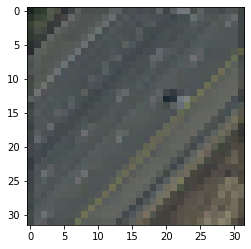

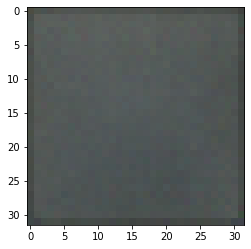

In [45]:
conv_sandwich()

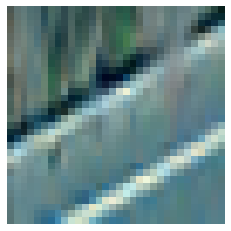

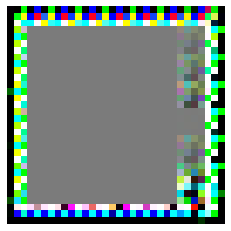

In [46]:
# Load model
od = load_detector(save_model_path)

# plot original and reconstructed instance
idx = 1
X = clean_train_imgs[idx].reshape(1, 32, 32, 3)
X_recon = od.ae(X)
plt.imshow(X.reshape(32, 32, 3)); plt.axis('off'); plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 3)); plt.axis('off')
plt.show()